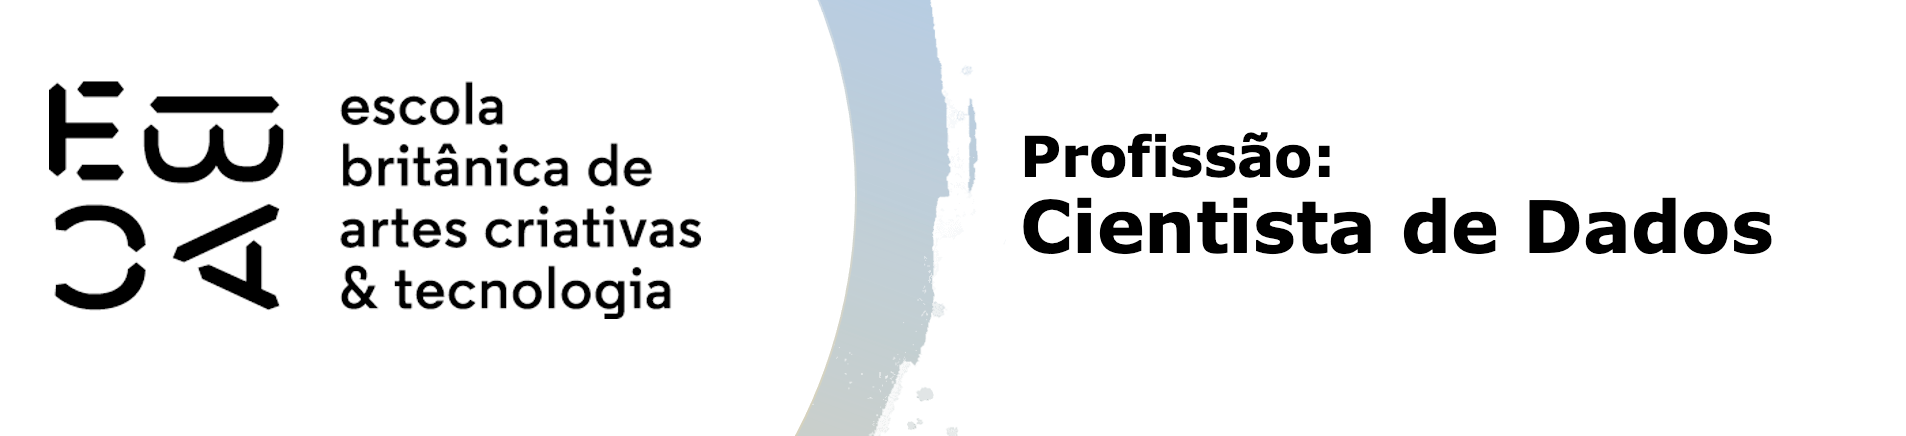

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
# Criando conjuntos de treinamento e teste
df_train = df[df['data_ref'] <= '2015-12-01'].copy()
df_test = df[df['data_ref'] > '2015-12-01'].copy()

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [3]:
# Número total de linhas na base de dados
linhas = len(df)

# Número de linhas para cada mês em data_ref
meses = df['data_ref'].dt.strftime('%Y-%m').value_counts().reset_index()
meses.columns = ['Mês', 'Número de Linhas']

print("Número total de linhas na base de dados:", linhas)
print("Número de linhas para cada mês em data_ref:")
print(meses)

Número total de linhas na base de dados: 750000
Número de linhas para cada mês em data_ref:
        Mês  Número de Linhas
0   2015-01             50000
1   2015-02             50000
2   2015-03             50000
3   2015-04             50000
4   2015-05             50000
5   2015-06             50000
6   2015-07             50000
7   2015-08             50000
8   2015-09             50000
9   2015-10             50000
10  2015-11             50000
11  2015-12             50000
12  2016-01             50000
13  2016-02             50000
14  2016-03             50000


In [4]:
# Função para calcular o Information Value
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [5]:
# Estatísticas univariadas para variáveis quantitativas
desc_quantitativas = df.describe()

# Contagem de valores únicos para variáveis qualitativas
desc_qualitativas = df.select_dtypes(include=['object']).nunique()

# Frequência de cada categoria para variáveis qualitativas
freq_qualitativas = {}
for col in df.select_dtypes(include=['object']).columns:
    freq_qualitativas[col] = df[col].value_counts()

# Exibindo as estatísticas e frequências
print("Estatísticas Univariadas para Variáveis Quantitativas:")
print(desc_quantitativas)
print("\nContagem de Valores Únicos para Variáveis Qualitativas:")
print(desc_qualitativas)
print("\nFrequência de Cada Categoria para Variáveis Qualitativas:")
for col, freq in freq_qualitativas.items():
    print(f"\n{col}:\n{freq}")

Estatísticas Univariadas para Variáveis Quantitativas:
               index     qtd_filhos          idade  tempo_emprego  \
count  750000.000000  750000.000000  750000.000000  624043.000000   
mean     8319.272793       0.433251      43.804733       7.748574   
std      4809.281774       0.739379      11.229868       6.687455   
min         0.000000       0.000000      22.000000       0.117808   
25%      4147.000000       0.000000      34.000000       3.049315   
50%      8324.000000       0.000000      43.000000       6.046575   
75%     12487.000000       1.000000      53.000000      10.183562   
max     16649.000000      14.000000      68.000000      42.906849   

       qt_pessoas_residencia         renda  
count          750000.000000  7.500000e+05  
mean                2.212241  2.323854e+04  
std                 0.903428  7.910601e+04  
min                 1.000000  1.076700e+02  
25%                 2.000000  3.467700e+03  
50%                 2.000000  7.861820e+03  
75%     

In [6]:
# Criando o metadados
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'

# Calculando o IV para as covariáveis
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)
        
# Removendo as variáveis 'index' e 'data_ref' do objeto metadados
metadados = metadados.drop(['index', 'data_ref'])
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.002185
posse_de_veiculo,object,0.0,2.0,covariavel,0.000108
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
qtd_filhos,int64,0.0,8.0,covariavel,0.000030
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
estado_civil,object,0.0,5.0,covariavel,0.001126
tipo_residencia,object,0.0,6.0,covariavel,0.003045
idade,int64,0.0,47.0,covariavel,0.017968
tempo_emprego,float64,125957.0,3004.0,covariavel,0.351920


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

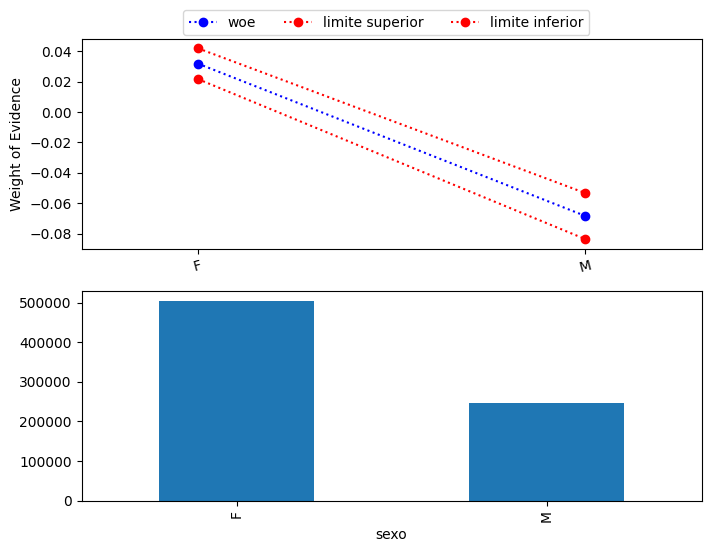

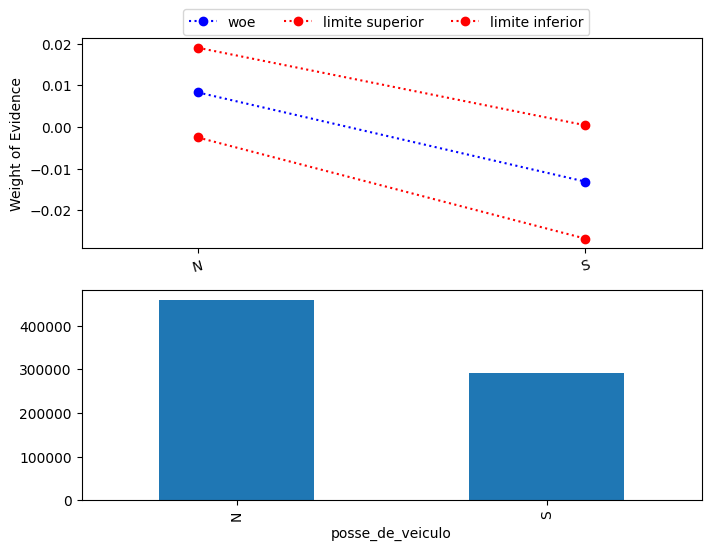

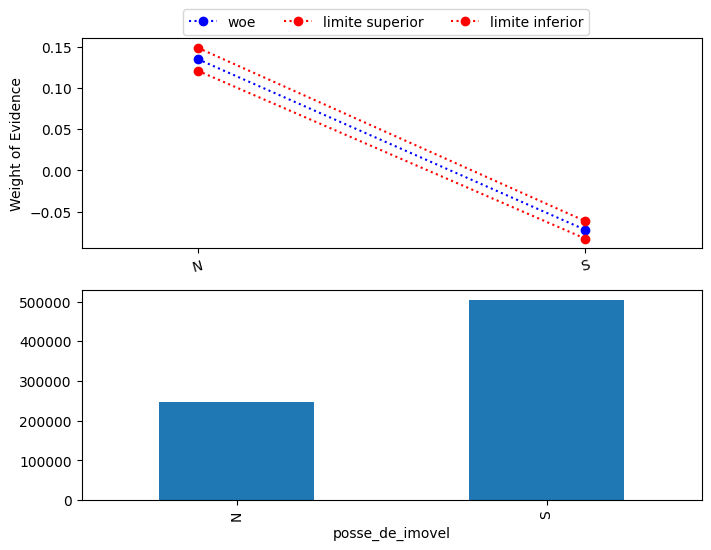

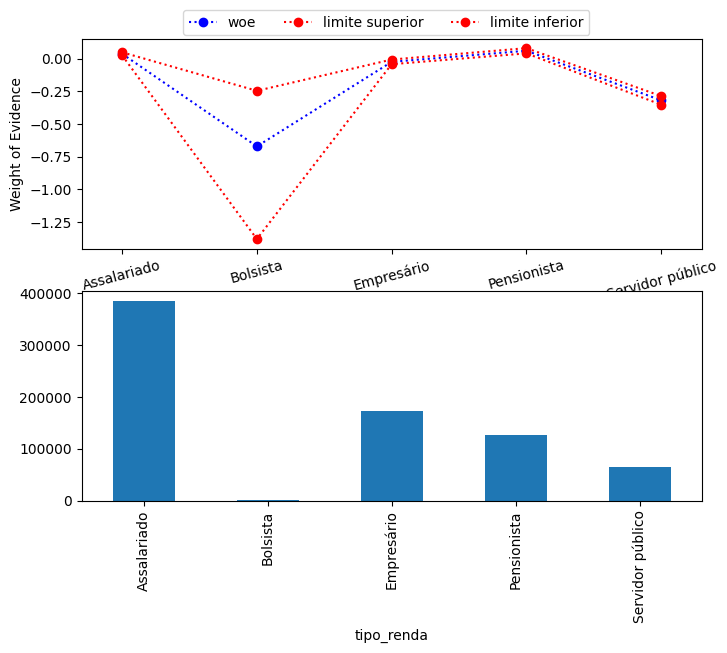

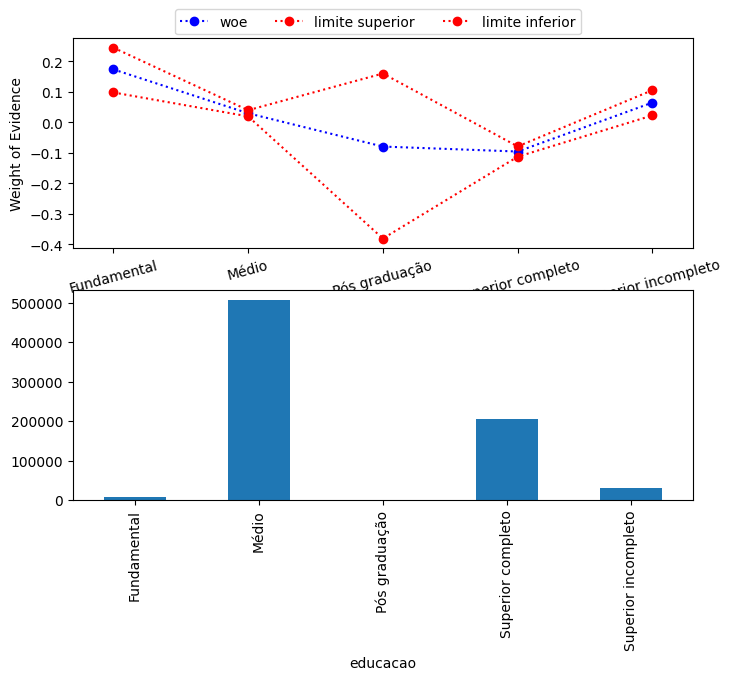

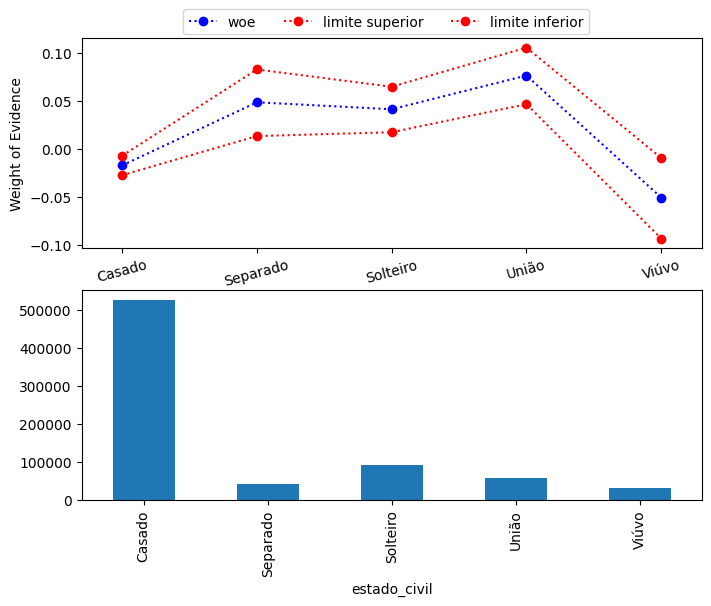

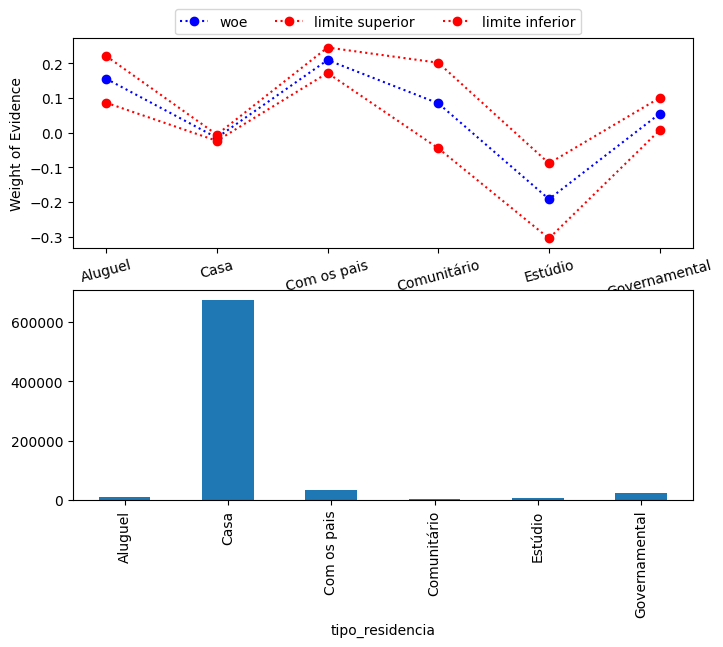

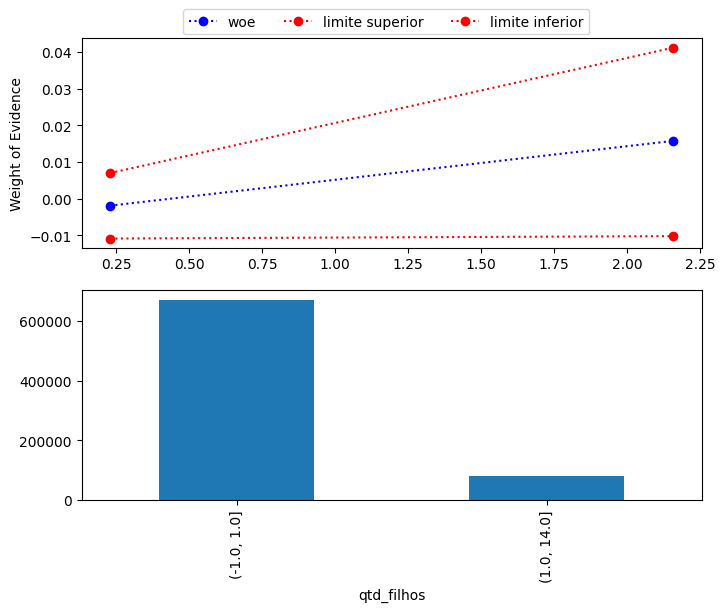

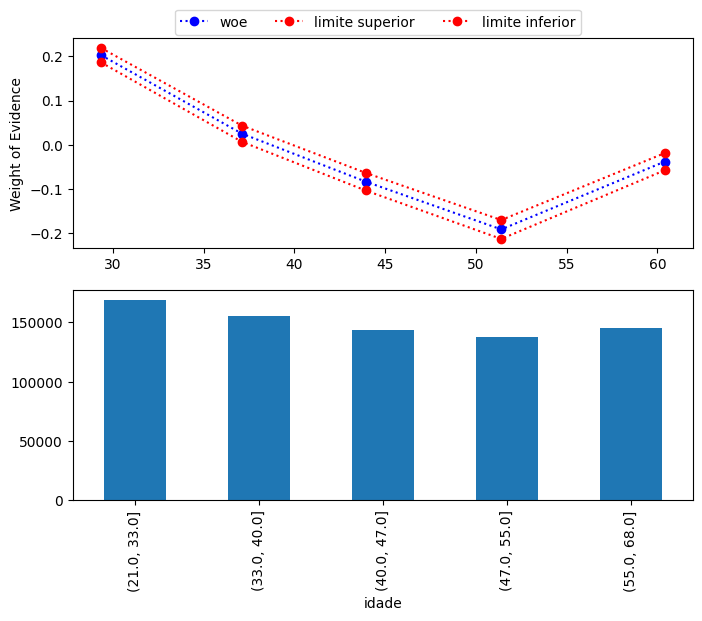

In [7]:
# Função para análise bivariada de variáveis discretas
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

# Função para análise bivariada de variáveis contínuas
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

# Loop para análise bivariada de variáveis discretas
for var in metadados[metadados.dtype=='object'].index:
    biv_discreta(var, df)

# Loop para análise bivariada de variáveis contínuas
for var in metadados[metadados.dtype=='int64'].index:
    if (metadados.loc[var, 'valores_unicos']>5):
        biv_continua(var, 5, df);
    else:
        biv_continua(var, metadados.loc[var,'valores_unicos'], df)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               750000
Model:                                     GLM   Df Residuals:                   749975
Model Family:                         Binomial   Df Model:                           24
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.8357e+05
Date:                         Sun, 01 Oct 2023   Deviance:                   3.6714e+05
Time:                                 14:47:33   Pearson chi2:                 4.63e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.05742
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9777      0.159      6.164      0.000       0.667       1.289
posse_de_imovel[T.S]                 0.0913      0.009      9.632      0.000       0.073       0.110
tipo_renda[T.Bolsista]               0.1483      0.269      0.552      0.581      -0.378       0.675
tipo_renda[T.Empresário]             0.0488      0.011      4.342      0.000       0.027       0.071
tipo_renda[T.Pensionista]            0.0642      0.016      4.027      0.000       0.033       0.095
tipo_renda[T.Servidor público]       0.0279      0.019      1.505      0.132      -0.008       0.064
educacao[T.Graduação/Pós]            0.1281      0.040      3.230      0.001       0.050       0.206
educacao[T.Médio]                    0.0698      0.039      1.797      0.072      -0.006       0.146
educacao[T.Superior incompleto]      0.1127      0.044      2.535      0.011       0.026       0.200
tipo_residencia[T.Casa]              0.0624      0.036      1.746      0.081      -0.008       0.133
tipo_residencia[T.Com os pais]       0.0542      0.040      1.349      0.177      -0.025       0.133
tipo_residencia[T.Comunitário]       0.1781      0.074      2.423      0.015       0.034       0.322
tipo_residencia[T.Estúdio]           0.0465      0.067      0.696      0.486      -0.084       0.177
tipo_residencia[T.Governamental]     0.0429      0.043      0.996      0.319      -0.042       0.127
sexo[T.M]                            0.1210      0.011     11.516      0.000       0.100       0.142
estado_civil[T.Separado]             0.0060      0.076      0.079      0.937      -0.144       0.156
estado_civil[T.Solteiro]             0.0343      0.075      0.459      0.646      -0.112       0.181
estado_civil[T.União]               -0.0307      0.016     -1.869      0.062      -0.063       0.001
estado_civil[T.Viúvo]                0.0842      0.078      1.085      0.278      -0.068       0.236
posse_de_veiculo[T.S]               -0.0239      0.010     -2.401      0.016      -0.043      -0.004
renda                                0.0001   1.05e-06    121.352      0.000       0.000       0.000
tempo_emprego                        0.0270      0.001     19.263      0.000       0.024       0.030
idade                                0.0003      0.001      0.445      0.656      -0.001       0.001
qt_pessoas_residencia                0.0412      0.074      0.557      0.578      -0.104       0.186
qtd_filhos                          -0.0424      0.074     -0.572      0.567      -0.188       0.103
====================================================================================================
"""

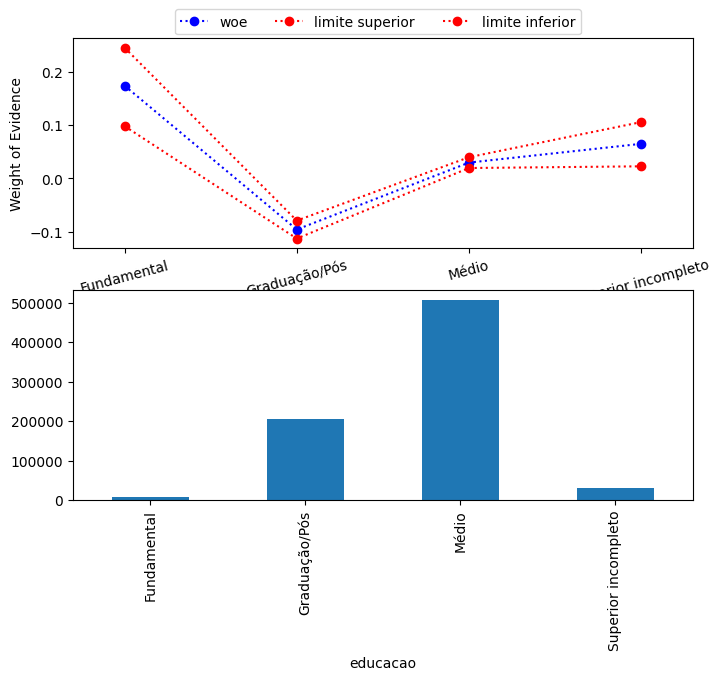

In [8]:
# Tratando valores missing em tempo_emprego
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

# Realizando agrupamentos de categorias para a variável 'educacao'
df['educacao'].replace({'Pós graduação': 'Graduação/Pós', 'Superior completo': 'Graduação/Pós'}, inplace=True)

# Realizando uma análise bivariada para a variável 'educacao'
biv_discreta('educacao', df)

# Criando uma fórmula para a regressão logística
formula = '''
    mau ~ renda + tempo_emprego + idade + posse_de_imovel + tipo_renda + educacao + tipo_residencia + 
          sexo + qt_pessoas_residencia + estado_civil + posse_de_veiculo + qtd_filhos
'''

# Ajustando o modelo de regressão logística
rl = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()

# Exibindo o resumo do modelo
rl.summary()

In [9]:
# Criando uma fórmula simplificada para a regressão logística
formula_simplificada = '''
    mau ~ renda + tempo_emprego + posse_de_imovel + sexo
'''

# Ajustando um modelo de regressão logística simplificado
rl_simplificado = smf.glm(formula_simplificada, data=df, family=sm.families.Binomial()).fit()

# Exibindo o resumo do modelo simplificado
rl_simplificado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               750000
Model:                                     GLM   Df Residuals:                   749995
Model Family:                         Binomial   Df Model:                            4
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.8362e+05
Date:                         Sun, 01 Oct 2023   Deviance:                   3.6724e+05
Time:                                 14:47:42   Pearson chi2:                 4.63e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.05730
Covariance Type:                     nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.2272      0.011    114.179      0.000       1.206       1.248
posse_de_imovel[T.S]     0.0974      0.009     10.605      0.000       0.079       0.115
sexo[T.M]                0.0989      0.010     10.329      0.000       0.080       0.118
renda                    0.0001   1.05e-06    121.955      0.000       0.000       0.000
tempo_emprego            0.0275      0.001     20.041      0.000       0.025       0.030
========================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [12]:
# Calculando o score com base no modelo de regressão logística
df['score'] = rl.predict(df)

# Função para calcular métricas e imprimir resultados
def calcular_metricas(df, nome_base):
    # Acurácia
    acc = metrics.accuracy_score(df.mau, df.score > 0.068)
    
    # AUC
    fpr, tpr, thresholds = metrics.roc_curve(df.mau, df.score)
    auc = metrics.auc(fpr, tpr)
    
    # Gini
    gini = 2 * auc - 1
    
    # KS
    ks = ks_2samp(df.loc[df.mau == 1, 'score'], df.loc[df.mau != 1, 'score']).statistic

    print(f'Métricas na base {nome_base}:\n')
    print('Acurácia: {0:.1%}'.format(acc))
    print('AUC: {0:.1%}'.format(auc))
    print('GINI: {0:.1%}'.format(gini))
    print('KS: {0:.1%}\n'.format(ks))

# Base completa
calcular_metricas(df, 'completa')

# Separando por ano
df['ano'] = df['data_ref'].dt.year
df_modelo = df[df['ano'] == 2015].copy()
df_oot = df[df['ano'] == 2016].copy()

# Métricas para o ano de modelo
df_modelo['score'] = rl.predict(df_modelo)
calcular_metricas(df_modelo, 'modelo')

# Métricas para o out-of-time
df_oot['score'] = rl.predict(df_oot)
calcular_metricas(df_oot, 'out-of-time')

Métricas na base completa:

Acurácia: 7.8%
AUC: 22.3%
GINI: -55.3%
KS: 41.6%

Métricas na base modelo:

Acurácia: 6.1%
AUC: 23.3%
GINI: -53.3%
KS: 39.5%

Métricas na base out-of-time:

Acurácia: 14.7%
AUC: 27.3%
GINI: -45.3%
KS: 33.2%



<font color="darkolivegreen">
A acurácia do modelo na base completa é baixa, indicando que a simples previsão da categoria predominante não é eficaz.<br>

O AUC mostra que o modelo tem alguma capacidade de discriminação, mas ainda é relativamente baixo.

O GINI, é negativo em todas as bases, o que sugere que o modelo não possui uma capacidade de discriminação muito forte.

O KS tem valores baixos, sugerindo um desempenho limitado do modelo.
</font>